In [34]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from file import save_file
from statistics import mean
from datetime import date
import file

In [35]:
# Define the ticker symbol
tickerSymbol = 'TQQQ'

# Get data on this ticker
tickerData = yf.Ticker(tickerSymbol)

# Get the historical prices for this ticker
history = tickerData.history(interval='1wk', start='2021-1-1', end=date.today())
# display(history)

In [36]:
CL = history['Low'].shift(-1) / history['Close'] - 1
print(f'{tickerSymbol} Close to next Low')
print(f'  20%: {CL.quantile(0.2):.2%}')
print(f'  50%: {CL.quantile(0.5):.2%}')
print(f'  80%: {CL.quantile(0.8):.2%}')

TQQQ Close to next Low
  20%: -10.38%
  50%: -4.41%
  80%: -1.43%


In [37]:
max_weeks = 50
gap = 0
option_prices = {
    1: [56/1.42, 57/1.23, 59/1.54, 83/1.96],
    2: [56/2, 57/2.03, 59/2.34, 83/3.05],
    3: [56/2.53, 57/2.68, 59/2.71, 83/3.75],
    4: [52/3.22, 56/3.1, 57/2.98, 59/3.15, 83/4.65],
    5: [56/3.42, 57/3.08, 59/3.31, 83/4.45],
    6: [56/3.47, 57/3.7, 59/3.9, 83/5.9],
    7: [57/4.15, 59/3.43, 83/6.0],
    8: [56/4.4],
    9: [52/4.87],
    11: [83/8.25],
    19: [59/7.37],
    20: [57/7.37],
    21: [56/7.3],
    22: [52/7.65],
    24: [83/12.52],
    32: [59/10.23],
    33: [57/10.02],
    34: [56/9.95],
    35: [52/9.98],
    36: [59/10.8],
    37: [57/10.57],
    38: [56/10.75],
    39: [52/10.42]
}

print('raw option leverages:')
for w in sorted(option_prices.keys()):
    print(f'\t{w:2}w', *[f'{x:4.1f}' for x in option_prices[w]])

option_leverage = {w:mean(option_prices[w]) for w in option_prices}

# normalize values so longer expirations have lower leverage
option_leverage = {k: v for k, v in zip(sorted(option_leverage.keys()), sorted(option_leverage.values(), reverse=True))}

print('sorted mean option leverage, break even:')
for w, v in sorted(option_leverage.items()):
    print(f'\t{w:2}w {v:4.1f} {gap + 100/v:4.1f}%')
print(f'option gap: {gap:.2f}%')

file.save_option_leverage(tickerSymbol, option_leverage)

raw option leverages:
	 1w 39.4 46.3 38.3 42.3
	 2w 28.0 28.1 25.2 27.2
	 3w 22.1 21.3 21.8 22.1
	 4w 16.1 18.1 19.1 18.7 17.8
	 5w 16.4 18.5 17.8 18.7
	 6w 16.1 15.4 15.1 14.1
	 7w 13.7 17.2 13.8
	 8w 12.7
	 9w 10.7
	11w 10.1
	19w  8.0
	20w  7.7
	21w  7.7
	22w  6.8
	24w  6.6
	32w  5.8
	33w  5.7
	34w  5.6
	35w  5.2
	36w  5.5
	37w  5.4
	38w  5.2
	39w  5.0
sorted mean option leverage, break even:
	 1w 41.6  2.4%
	 2w 27.1  3.7%
	 3w 21.8  4.6%
	 4w 18.0  5.6%
	 5w 17.8  5.6%
	 6w 15.2  6.6%
	 7w 14.9  6.7%
	 8w 12.7  7.9%
	 9w 10.7  9.4%
	11w 10.1  9.9%
	19w  8.0 12.5%
	20w  7.7 12.9%
	21w  7.7 13.0%
	22w  6.8 14.7%
	24w  6.6 15.1%
	32w  5.8 17.3%
	33w  5.7 17.6%
	34w  5.6 17.8%
	35w  5.5 18.3%
	36w  5.4 18.5%
	37w  5.2 19.2%
	38w  5.2 19.2%
	39w  5.0 20.0%
option gap: 0.00%


In [38]:
stock_change = [None] # no change for 0 weeks
option_performance = []
history['Change'] = history['Close'].pct_change(periods=1) * 100
for weeks in range(1, max_weeks):
    stock_changes = history['Close'].pct_change(periods=weeks) * 100
    stock_change.append(stock_changes.median() * 52 / weeks) # annualized

    if weeks in option_leverage:
        lvr = option_leverage[weeks]
        option_profits = ((stock_changes[weeks:] - gap) * lvr - 100).clip(lower=-100)
        mean_profit = option_profits.mean() * 52 / weeks # annualized
        positive_percent = (option_profits > 0).mean() * 100
        option_performance.append([weeks, mean_profit, positive_percent])
        history[f'Option {weeks}w'] = option_profits # ? * 52 / weeks # annualized

In [39]:
print('Option performance (weeks, profit, positive):')
for p in option_performance:
    print(f'\t{p[0]:2}w {p[1]:4.0f}% {p[2]:3.0f}%')

Option performance (weeks, profit, positive):
	 1w 2922%  43%
	 2w 1270%  45%
	 3w 1022%  50%
	 4w  676%  46%
	 5w  750%  49%
	 6w  527%  47%
	 7w  504%  47%
	 8w  355%  49%
	 9w  216%  48%
	11w  220%  48%
	19w  217%  53%
	20w  211%  56%
	21w  217%  58%
	22w  175%  53%
	24w  183%  56%
	32w  178%  60%
	33w  177%  61%
	34w  176%  61%
	35w  168%  61%
	36w  166%  60%
	37w  156%  59%
	38w  156%  59%
	39w  144%  59%


In [40]:

save_file(tickerSymbol, option_performance)


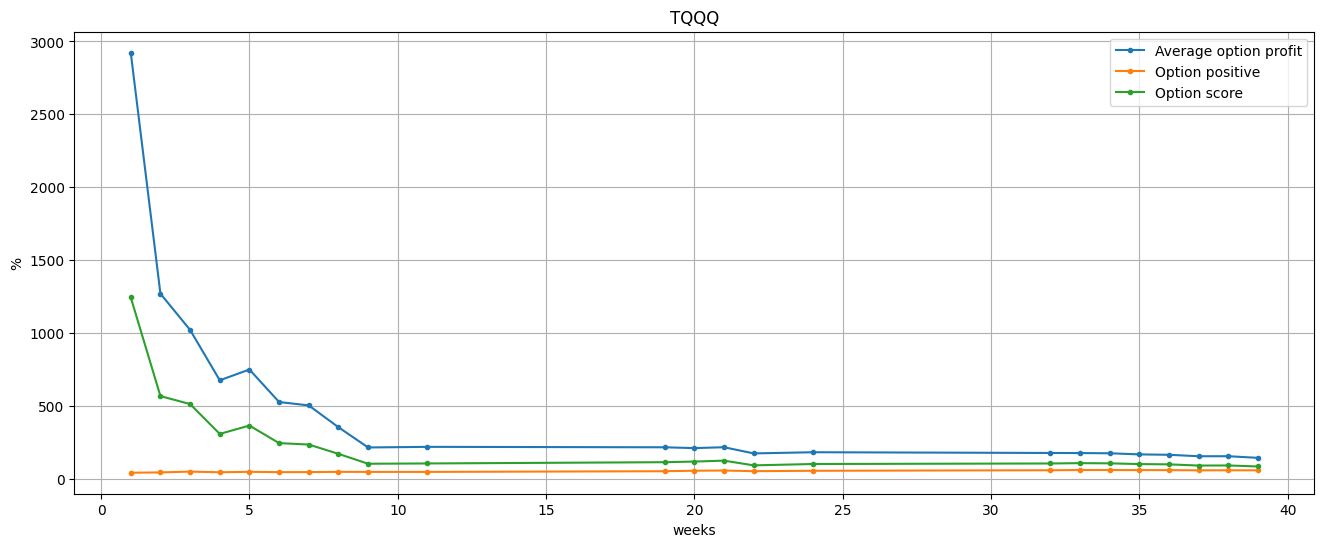

In [45]:
plt.figure(figsize=(16,6))
option_weeks = [p[0] for p in option_performance]
option_profit = [p[1] for p in option_performance]
option_positive = [p[2] for p in option_performance]
option_score = [x * y / 100 for x, y in zip(option_profit, option_positive)]
plt.plot(option_weeks, option_profit, label='Average option profit', marker='.')
plt.plot(option_weeks, option_positive, label='Option positive', marker='.')
plt.plot(option_weeks, option_score, label='Option score', marker='.')
plt.legend()
plt.title(tickerSymbol)
plt.xlabel('weeks')
plt.ylabel('%')
plt.grid()
plt.show()

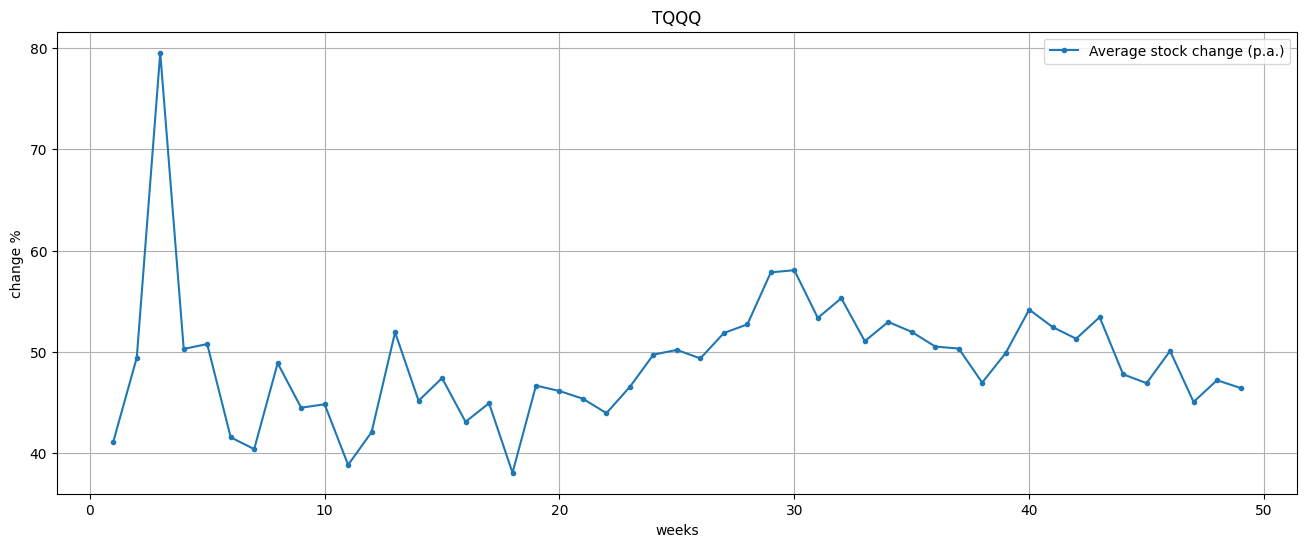

In [42]:
plt.figure(figsize=(16,6))
plt.plot(stock_change, label='Average stock change (p.a.)', marker='.')
plt.legend(loc='upper right')
plt.title(tickerSymbol)
plt.xlabel('weeks')
plt.ylabel('change %')
plt.grid()
plt.show()


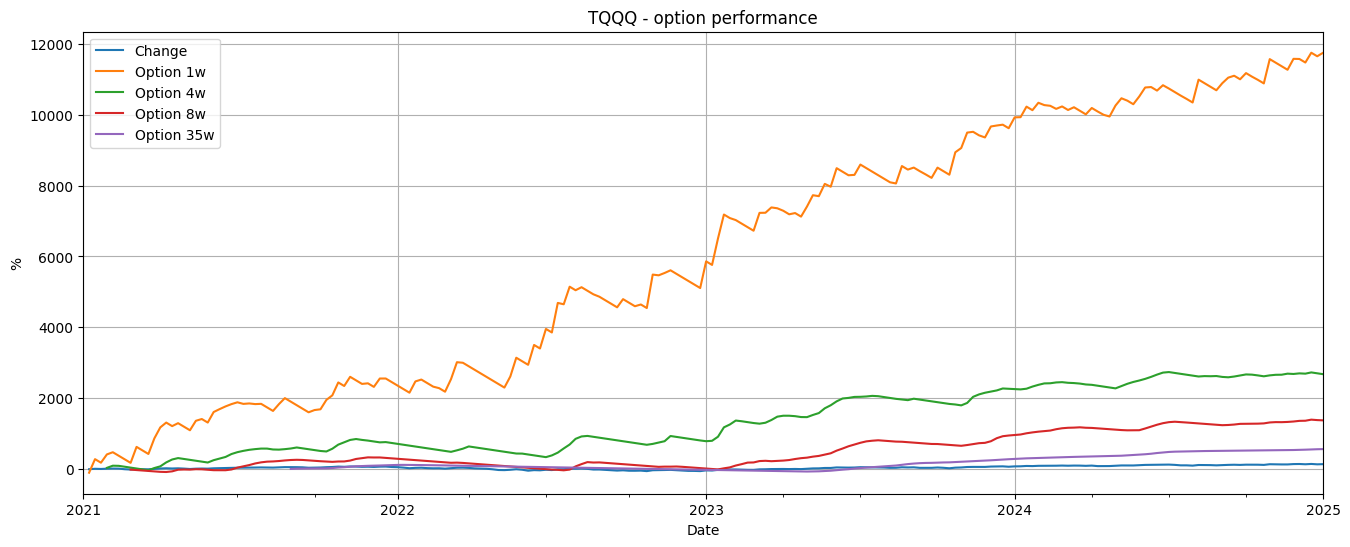

In [43]:
plt.figure(figsize=(16,6))
history['Change'].cumsum().plot()

for w in [1,4,8,35]:
    (history[f'Option {w}w'].cumsum()/w).plot()

plt.legend(loc='upper left')
plt.title(f'{tickerSymbol} - option performance')
plt.ylabel('%')
# plt.yscale('log')
plt.grid()
plt.show()


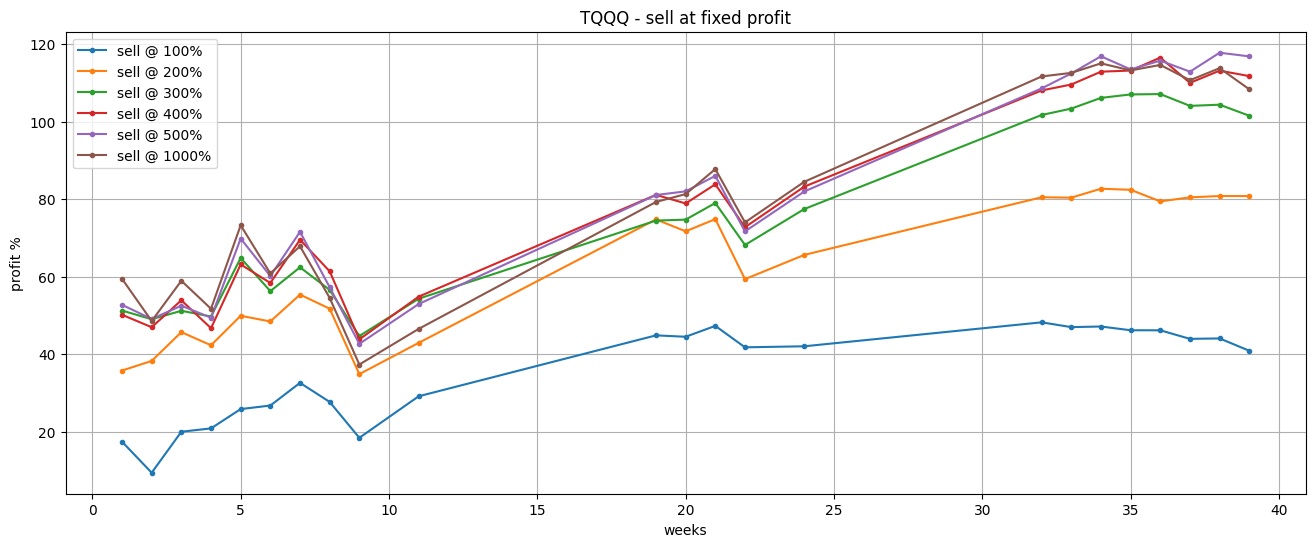

In [44]:
plt.figure(figsize=(16,6))

for maxprofit in [100,200,300,400,500,1000]:
    data = {}
    for weeks in option_leverage:
        lvr = option_leverage[weeks]
        WStart = history.Close.shift(weeks)
        WHigh = history.High.rolling(window=weeks).max()
        eow_profit = (((history.Close / WStart - 1) * 100 - gap) * lvr - 100).clip(lower=-100)
        wmax_profit = (((WHigh / WStart - 1) * 100 - gap) * lvr - 100).clip(upper=maxprofit)
        profit = wmax_profit.where(wmax_profit >= maxprofit, eow_profit)
        data[weeks] = profit[weeks:].mean()

    plt.plot(*zip(*sorted(data.items())), label=f'sell @ {maxprofit}%', marker='.')

plt.legend()
plt.title(f'{tickerSymbol} - sell at fixed profit')
plt.xlabel('weeks')
plt.ylabel('profit %')
plt.grid()
plt.show()